In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 6 2021

@authors: R. van Hoof & A. Lozano
"""

# %matplotlib inline

'\nCreated on Wed May 6 2021\n\n@authors: R. van Hoof & A. Lozano\n'

In [2]:
import time
import os.path
import pickle # needed to store the results
from copy import deepcopy
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score as MI
from skopt.utils import use_named_args
from skopt.space import Integer, Categorical, Real
from skopt.utils import cook_initial_point_generator
from skopt import gp_minimize

########################
### Custom functions ###
########################
from ninimplant import pol2cart, get_xyz # matrix rotation/translation ect
from lossfunc import DC, KL, get_yield, hellinger_distance
from electphos import create_grid, reposition_grid, implant_grid, get_phosphenes, prf_to_phos, gen_dummy_phos, get_cortical_magnification, cortical_spread
import visualsectors as gvs

# ignore "True-divide" warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
##########
## INIT ##
##########

# datafolder = '/path/to/data/'
# outputfolder = '/path/to/data/'
# datafolder = 'F:/Rick/Surfdrive_BACKUP/Data/NESTOR/HCP/subjects/'
# datafolder = r'C:/Users/Lozano/Desktop/NIN/bayesian_optimization_paper/data/subjects/'
# outputfolder =  r'C:/Users/Lozano/Desktop/NIN/bayesian_optimization_paper/data/output/'
datafolder = "C:/Users/user/YongtaeC/vimplant0812/data/input/102311/"
outputfolder = "C:/Users/user/YongtaeC/vimplant0812/data/output/102311/"
os.makedirs(outputfolder, exist_ok=True)

# determine range of parameters used in optimization
dim1 = Integer(name='alpha', low=-90, high=90) # visual degrees 
dim2 = Integer(name='beta', low=-15, high=110) # visual degrees - -15 is probably lowest possible angle, otherwise other hem is in the way if hem = RH -> low = -110, high = 15
dim3 = Integer(name='offset_from_base', low=0, high=40) # in mm
dim4 = Integer(name='shank_length', low=10, high=40) # mm
dimensions = [dim1, dim2, dim3, dim4]

num_calls = 150
x0 = (0,0,20,25) # initial values for the four dimensions
num_initial_points = 10
dc_percentile = 50
n_contactpoints_shank = 10
spacing_along_xy = 1
WINDOWSIZE = 1000

# lists of loss term combinations to loop through
    # Dice Coefficient (1, 0, 0)
    # Yield (0, 1, 0)
    # Hellinger Distance (0, 0, 1)
loss_comb = ([(1, 0.1, 1)]) # weights for loss terms
loss_names = (['dice-yield-HD']) # substring in output filename

# lists of target maps to loop through
targ_comb = ([gvs.upper_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False), 
              gvs.lower_sector(windowsize=WINDOWSIZE, fwhm=800, radiusLow=0, radiusHigh=500, plotting=False),
              gvs.inner_ring(windowsize=WINDOWSIZE, fwhm=400, radiusLow=0, radiusHigh=250, plotting=False),
              gvs.complete_gauss(windowsize=1000, fwhm=1200, radiusLow=0, radiusHigh=500, center=None, plotting=False)])
targ_names = (['targ-upper', 'targ-lower', 'targ-inner', 'targ-full'])

# constants pRF model
cort_mag_model = 'wedge-dipole' # which cortex model to use for the cortical magnification
view_angle = 90 #in degrees of visual angle
amp = 100 #stimulation amplitude in micro-amp (higher stimulation -> more tissue activated)

# INIT Bayes
amax = 1
bmax = 1
cmax = 1000
N=5
delta=0.2
thresh=0.05

# subjects to include
subj_list = [118225, 144226, 162935, 176542, 187345, 200614, 251833, 389357, 547046, 671855, 789373, 901139,  
100610, 125525, 145834, 164131, 177140, 191033, 201515, 257845, 393247, 550439, 680957, 814649, 901442, 
102311, 126426, 146129, 164636, 177645, 191336, 203418, 263436, 395756, 552241, 690152, 818859, 905147, 
102816, 128935, 146432, 165436, 177746, 191841, 204521, 283543, 397760, 562345, 706040, 825048, 910241, 
104416, 130114, 146735, 167036, 178142, 192439, 205220, 318637, 401422, 572045, 724446, 826353, 926862, 
105923, 130518, 146937, 167440, 178243, 192641, 209228, 320826, 406836, 573249, 725751, 833249, 927359, 
108323, 131217, 148133, 169040, 178647, 193845, 212419, 330324, 412528, 581450, 732243, 859671, 942658, 
109123, 131722, 150423, 169343, 180533, 195041, 214019, 346137, 429040, 585256, 751550, 861456, 943862, 
111312, 132118, 155938, 169444, 181232, 196144, 214524, 352738, 436845, 601127, 757764, 871762, 951457, 
111514, 134627, 156334, 169747, 181636, 197348, 221319, 360030, 463040, 617748, 765864, 872764, 958976, 
114823, 134829, 157336, 171633, 182436, 198653, 233326, 365343, 467351, 627549, 770352, 878776, 966975, 
115017, 135124, 158035, 172130, 182739, 199655, 239136, 380036, 525541, 638049, 771354, 878877, 971160, 
115825, 137128, 158136, 173334, 185442, 200210, 246133, 381038, 536647, 644246, 782561, 898176, 973770, 
116726, 140117, 159239, 175237, 186949, 200311, 249947, 385046, 541943, 654552, 783462, 899885, 995174, 'fsaverage']

subj_list = [100206]
subj_list = [102311]

In [4]:
################################################
## Functions related to Bayesian optimization ##
################################################

def custom_stopper(res, N=5, delta=0.2, thresh=0.05):
    '''
    Returns True (stops the optimization) when 
    the difference between best and worst of the best N are below delta AND the best is below thresh
    
    N = last number of cost values to track
    delta = ratio best and worst
    
    '''
    
    if len(res.func_vals) >= N:
        func_vals = np.sort(res.func_vals)
        worst = func_vals[N - 1]
        best = func_vals[0]
        
        return (abs((best - worst)/worst) < delta) & (best < thresh)
    else:
        return None

@use_named_args(dimensions=dimensions)
def f(alpha, beta, offset_from_base, shank_length):
    """
    This function encapsulates the electrode placement procedure and returns the cost value by 
    comparing the resulting phosphene map with the target map.    
    * First it creats a grid based on the four parameters. 
    * Phosphenes are generated based on the grid's contact points, 
      and their sizes are determined using cortical magnification and spread values. 
    * These phosphenes are converted into a 2D image representation. 
      The function then computes the dice coefficient and yield, and calculates the Hellinger 
      distance between the generated image and a target density. 
    * The resulting cost is a combination of these factors, 
      with penalties applied if the grid is invalid. 
    * The function also handles cases of invalid values and prints diagnostic information. 
    * Ultimately, the function returns the calculated cost used by the bayesopt algorithm.
    """
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)    
    
    # create grid
    orig_grid = create_grid(start_location, shank_length, n_contactpoints_shank, spacing_along_xy, offset_from_origin=0)
    
    # implanting grid
    _, contacts_xyz_moved, _, _, _, _, _, _, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    # get angle, ecc and rfsize for contactpoints (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)    
    phosphenes = get_phosphenes(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)   
    phosphenes_V3 = get_phosphenes(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    
    #the inverse cortical magnification in degrees (visual angle)/mm tissue
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model) 
    spread = cortical_spread(amp) #radius of current spread in the tissue, in mm
    sizes = spread*M #radius of current spread * cortical magnification = rf radius in degrees
    sigmas = sizes / 2  # radius to sigma of gaussian
    
    # phosphene size based on CMF + stim amp
    phosphenes_V1[:,2] = sigmas

    # generate map using Gaussians
    # transforming obtained phosphenes to a 2d image    
    phospheneMap = np.zeros((WINDOWSIZE,WINDOWSIZE), 'float32') 
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)    
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()

    # bin_thesh determines size target
    bin_thresh=np.percentile(target_density, dc_percentile)# np.min(target_density) 

    # compute dice coefficient -> should be 1 -> invert cost 
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)

    # compute yield -> should be 1 -> invert cost
    grid_yield = get_yield(contacts_xyz_moved, good_coords)
    par2 = 1.0 - (b * grid_yield)

    # compute hellinger distance -> should be small -> keep cost
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())    
    
    ## validations steps
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        print('map is nan or 0')
    
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        print('Hellington is nan or inf')
    else:
        par3 = c * hell_d
    
    # combine cost functions
    cost = par1 + par2 + par3

    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    
    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    
    print('    ', "{:.2f}".format(cost), "{:.2f}".format(dice), "{:.2f}".format(grid_yield), "{:.2f}".format(par3), grid_valid)
    return cost

def f_manual(alpha, beta, offset_from_base, shank_length, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density):
    '''
    Copy from f, to obtain phosphene map and contact points for the optimized parameters. Used to visualize results.

    also returns coords used ect.
    '''
    
    penalty = 0.25
    new_angle = (float(alpha), float(beta), 0)
    
    # create grid
    orig_grid = create_grid(start_location, shank_length, n_contactpoints_shank, spacing_along_xy, offset_from_origin=0)

    # implanting grid
    ref_contacts_xyz, contacts_xyz_moved, refline, refline_moved, projection, ref_orig, ray_visualize, new_location, grid_valid = implant_grid(gm_mask, orig_grid, start_location, new_angle, offset_from_base)

    # get angle, ecc and rfsize for contactpoints in each ROI (phosphenes[0-2][:] 0 angle x 1 ecc x 2 rfsize)
    phosphenes =    get_phosphenes(contacts_xyz_moved, good_coords, polar_map, ecc_map, sigma_map)
    phosphenes_V1 = get_phosphenes(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)
    phosphenes_V2 = get_phosphenes(contacts_xyz_moved, good_coords_V2, polar_map, ecc_map, sigma_map)
    phosphenes_V3 = get_phosphenes(contacts_xyz_moved, good_coords_V3, polar_map, ecc_map, sigma_map)
    
    #the inverse cortical magnification in degrees (visual angle)/mm tissue
    M = 1 / get_cortical_magnification(phosphenes_V1[:,1], cort_mag_model)
    spread = cortical_spread(amp) #radius of current spread in the tissue, in mm
    sizes = spread*M #radius of current spread * cortical magnification = rf radius in degrees
    sigmas = sizes / 2  # radius to sigma of gaussian
    
    # phosphene size based on CMF + stim amp
    phosphenes_V1[:,2] = sigmas

    # generate map using Gaussians
    # transforming obtained phosphenes to a 2d image
    phospheneMap = np.zeros((WINDOWSIZE,WINDOWSIZE), 'float32')
    phospheneMap = prf_to_phos(phospheneMap, phosphenes_V1, view_angle=view_angle, phSizeScale=1)
    phospheneMap /= phospheneMap.max()
    phospheneMap /= phospheneMap.sum()
    print(view_angle)
    
    # can we relate bin_thesh to an eccentricity value? -> taken care of by masking the targets -> CHANGE TO 0.99999
    bin_thresh=np.percentile(target_density, dc_percentile)# np.min(target_density) # bin_thesh determines size target

    # compute dice coefficient -> should be large -> invert cost 
    dice, im1, im2 = DC(target_density, phospheneMap, bin_thresh)
    par1 = 1.0 - (a * dice)

    # compute yield -> should be 1 -> invert cost
    grid_yield = get_yield(contacts_xyz_moved, good_coords)
    par2 = 1.0 - (b * grid_yield)  
    
    # very important to normalize target density to same range as phospheneMap!
    target_density /= target_density.max()
    target_density /= target_density.sum()        
    
    # compute Hellinger distance -> should be small -> keep cost
    hell_d = hellinger_distance(phospheneMap.flatten(), target_density.flatten())
    
    ## validations steps
    if np.isnan(phospheneMap).any() or np.sum(phospheneMap) == 0:
        par1 = 1
        print('map is nan or 0')
    
    if np.isnan(hell_d) or np.isinf(hell_d):
        par3 = 1
        print('Hellington is nan or inf')
    else:
        par3 = c * hell_d
    
    # combine cost functions
    cost = par1 + par2 + par3

    # when some contact points are outside of the hemisphere (convex), add penalty
    if not grid_valid:
        cost = par1 + penalty + par2 + penalty + par3 + penalty
    
    # check if cost contains invalid value
    if np.isnan(cost) or np.isinf(cost):
        cost = 3
    
    return grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap

number of subjects: 1
target:  targ-upper
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.60 0.24 0.50 0.89 True
     2.96 0.00 0.24 0.99 True
     2.83 0.08 0.28 0.94 True
     2.88 0.04 0.33 0.96 True
     2.96 0.01 0.20 0.99 True
     2.80 0.10 0.48 0.95 True
     3.59 0.06 0.18 0.92 False
     2.86 0.06 0.30 0.95 True
     3.57 0.08 0.31 0.94 False
map is nan or 0
Hellington is nan or inf
     3.71 0.00 0.42 1.00 False
     3.51 0.10 0.37 0.90 False
     2.82 0.07 0.47 0.94 True
     2.90 0.05 0.16 0.97 True
map is nan or 0
Hellington is nan or inf
     3.70 0.00 0.46 1.00 False
     2.77 0.11 0.41 0.92 True
     2.45 0.34 0.44 0.83 True
     2.54 0.27 0.36 0.85 True
     2.86 0.06 0.25 0.95 True
     3.49 0.12 0.42 0.91 False
     2.85 0.06 0.42 0.95 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.33 1.00 True
     2.44 0.34 0.42 0.83 True
     2.81 0.08 0.50 0.93 True
     2.81 0.08 0.50 0.93 True
     2.84 0.07 0.37 0.94 True
     2.53 0.28 0.43 0.85 True
     2.42 0.

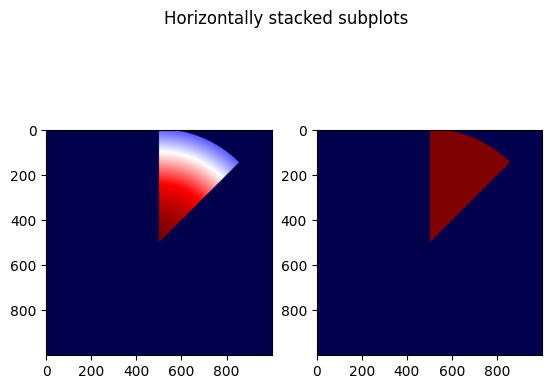

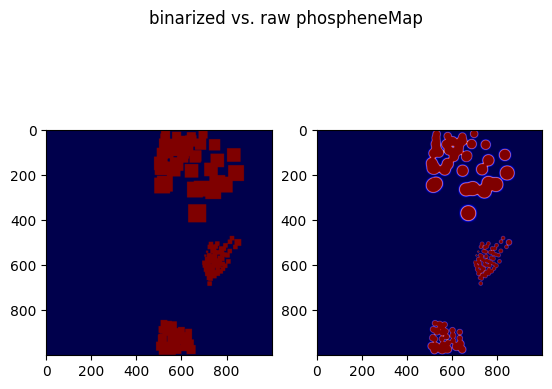

    max phospheneMap:  9.2152506e-05
     2.67 0.19 0.45 0.91 True
     3.62 0.05 0.27 0.95 False
     2.97 0.00 0.35 1.00 True
     3.64 0.05 0.22 0.96 False
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.32 1.00 True
     3.67 0.03 0.33 0.98 False
     3.63 0.05 0.22 0.95 False
     3.66 0.03 0.36 0.98 False
map is nan or 0
Hellington is nan or inf
     2.96 0.00 0.37 1.00 True
     3.62 0.05 0.39 0.95 False
     2.86 0.06 0.45 0.97 True
     2.98 0.00 0.22 1.00 True
     2.57 0.27 0.41 0.89 True
     2.50 0.33 0.41 0.87 True
     2.73 0.15 0.43 0.93 True
     2.99 0.00 0.12 1.00 True
     2.59 0.26 0.44 0.90 True
map is nan or 0
Hellington is nan or inf
     3.69 0.00 0.56 1.00 False
     2.89 0.03 0.41 0.97 True
     2.91 0.03 0.38 0.98 True
     2.90 0.04 0.38 0.97 True
     2.65 0.22 0.39 0.91 True
     3.70 0.00 0.27 0.98 False
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.29 1.00 True
     2.87 0.06 0.36 0.97 True
     2.88 0.04 0.35 0.95 True
     2.85 0

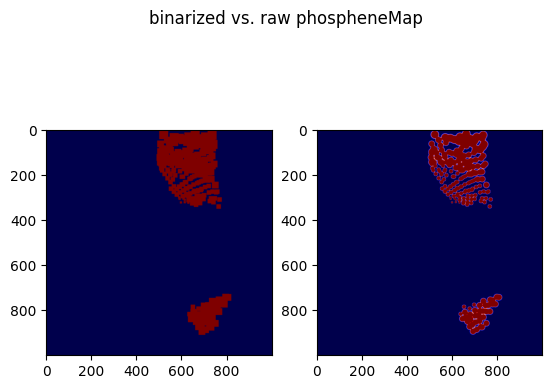

    max phospheneMap:  9.8368495e-05
target:  targ-lower
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.88 0.05 0.50 0.98 True
     3.70 0.00 0.47 1.00 False
     2.96 0.00 0.40 1.00 True
     2.97 0.00 0.26 1.00 True
     3.73 0.00 0.15 1.00 False
     2.97 0.00 0.35 1.00 True
     3.71 0.01 0.23 0.99 False
     2.96 0.00 0.39 1.00 True
map is nan or 0
Hellington is nan or inf
     2.96 0.00 0.38 1.00 True
     2.97 0.00 0.34 1.00 True
     3.64 0.05 0.35 0.97 False
     3.68 0.03 0.32 0.99 False
map is nan or 0
Hellington is nan or inf
     3.73 0.00 0.24 1.00 False
     2.97 0.00 0.35 1.00 True
     2.95 0.00 0.47 1.00 True
map is nan or 0
Hellington is nan or inf
     3.71 0.00 0.38 1.00 False
     2.96 0.00 0.44 1.00 True
     2.96 0.00 0.36 1.00 True
     2.98 0.00 0.22 1.00 True
map is nan or 0
Hellington is nan or inf
     2.96 0.00 0.36 1.00 True
     2.96 0.00 0.41 1.00 True
     2.95 0.00 0.47 1.00 True
     2.95 0.00 0.47 1.00 True
     2.99 0.00 0.10 1.00 True
     2.97 0.00 

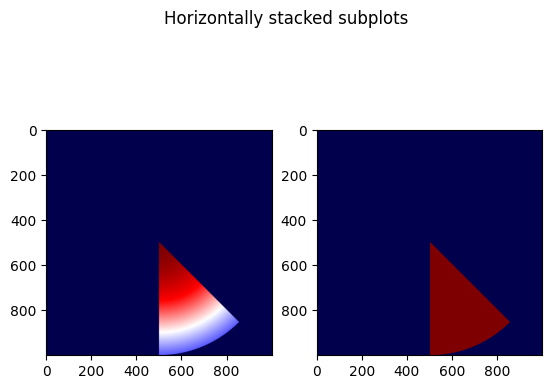

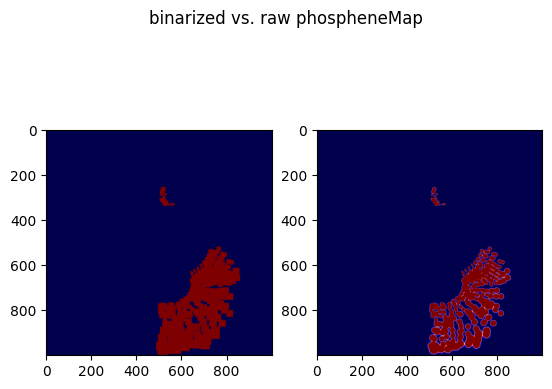

    max phospheneMap:  0.000111264955
     2.76 0.13 0.45 0.94 True
     2.78 0.10 0.49 0.93 True
     3.63 0.05 0.34 0.96 False
     3.65 0.04 0.23 0.96 False
     3.59 0.07 0.36 0.94 False
     3.65 0.04 0.34 0.97 False
     2.88 0.03 0.30 0.94 True
     2.89 0.04 0.34 0.96 True
     3.63 0.05 0.23 0.95 False
     2.43 0.40 0.19 0.85 True
     2.88 0.05 0.40 0.97 True
     2.42 0.40 0.12 0.83 True
     2.55 0.31 0.14 0.88 True
     2.61 0.25 0.16 0.88 True
     3.57 0.05 0.45 0.92 False
     2.89 0.05 0.29 0.97 True
     3.65 0.04 0.23 0.97 False
     3.55 0.09 0.46 0.94 False
     2.40 0.41 0.27 0.84 True
     2.67 0.20 0.44 0.91 True
     2.38 0.44 0.17 0.83 True
     2.45 0.39 0.17 0.85 True
     2.42 0.41 0.16 0.85 True
     2.43 0.36 0.41 0.83 True
     2.60 0.28 0.14 0.90 True
     2.33 0.46 0.22 0.81 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.32 1.00 True
     2.21 0.53 0.30 0.77 True
map is nan or 0
Hellington is nan or inf
     3.73 0.00 0.23 1.00 False
m

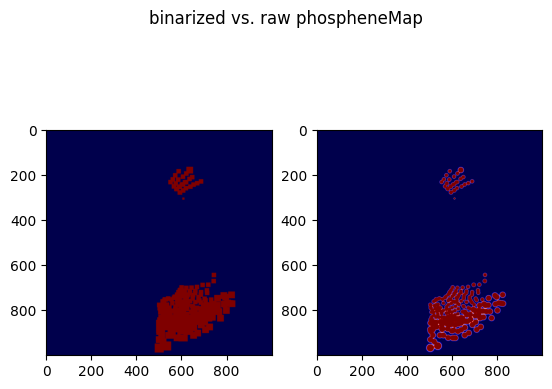

    max phospheneMap:  0.00017046169
target:  targ-inner
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.74 0.14 0.50 0.94 True
map is nan or 0
Hellington is nan or inf
     2.96 0.00 0.42 1.00 True
     2.97 0.00 0.31 1.00 True
     2.61 0.20 0.35 0.84 True
     3.40 0.18 0.26 0.86 False
     2.91 0.03 0.14 0.95 True
     3.42 0.16 0.41 0.87 False
     2.61 0.21 0.40 0.86 True
     2.60 0.22 0.28 0.84 True
     2.69 0.21 0.20 0.92 True
     2.68 0.20 0.33 0.91 True
     2.59 0.23 0.26 0.84 True
     3.37 0.20 0.35 0.85 False
     2.60 0.20 0.34 0.84 True
     2.52 0.26 0.39 0.83 True
     3.34 0.23 0.29 0.85 False
     3.58 0.07 0.41 0.95 False
     2.65 0.21 0.30 0.88 True
     2.58 0.24 0.32 0.85 True
     2.64 0.19 0.33 0.86 True
     2.94 0.04 0.12 0.99 True
     2.54 0.26 0.36 0.84 True
     2.67 0.17 0.38 0.87 True
     2.77 0.09 0.32 0.89 True
     2.52 0.25 0.46 0.81 True
     2.49 0.28 0.42 0.81 True
     2.80 0.07 0.42 0.91 True
     3.25 0.27 0.38 0.81 False
     2.69 0.19 0.52

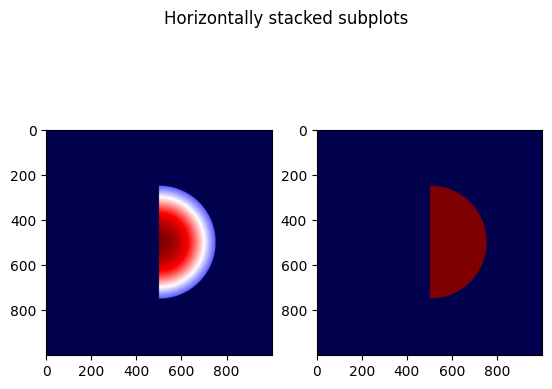

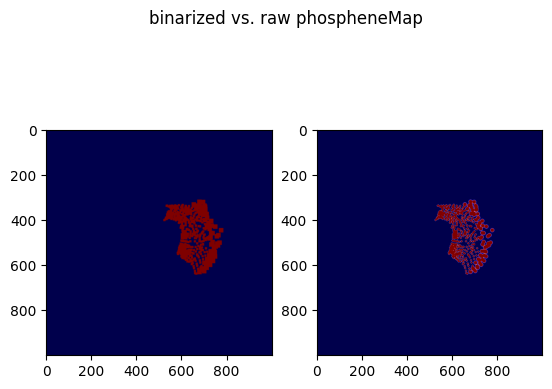

    max phospheneMap:  0.00032753588
     2.75 0.14 0.45 0.93 True
map is nan or 0
Hellington is nan or inf
     3.71 0.00 0.41 1.00 False
     2.48 0.33 0.40 0.85 True
     2.94 0.03 0.03 0.97 True
     3.38 0.20 0.26 0.85 False
map is nan or 0
Hellington is nan or inf
     2.98 0.00 0.21 1.00 True
     2.36 0.39 0.36 0.79 True
     2.85 0.06 0.27 0.93 True
     2.52 0.26 0.35 0.82 True
     3.50 0.13 0.17 0.89 False
     2.95 0.03 0.16 0.99 True
     2.34 0.40 0.46 0.78 True
     2.50 0.28 0.33 0.82 True
     2.42 0.33 0.39 0.79 True
     2.68 0.16 0.33 0.87 True
     2.81 0.09 0.15 0.91 True
     2.29 0.44 0.47 0.78 True
     2.43 0.33 0.51 0.81 True
     2.55 0.25 0.39 0.84 True
     2.22 0.50 0.53 0.77 True
     2.50 0.32 0.45 0.87 True
     2.76 0.11 0.36 0.90 True
     2.56 0.27 0.30 0.85 True
     2.37 0.35 0.58 0.78 True
     2.41 0.33 0.51 0.79 True
     2.47 0.32 0.41 0.83 True
     3.22 0.34 0.33 0.84 False
     2.44 0.32 0.44 0.80 True
     2.53 0.29 0.31 0.85 True
     2.

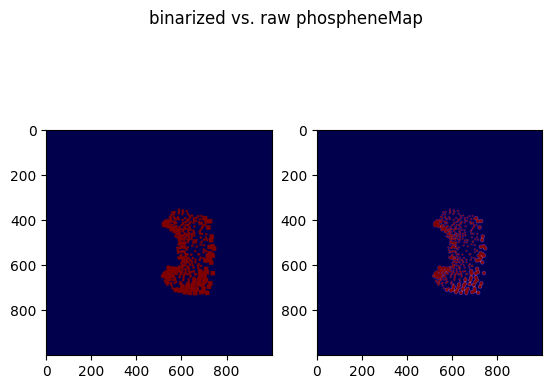

    max phospheneMap:  0.00049633463
target:  targ-full
loss:  dice-yield-HD
a,b,c:  1 0.1 1
     2.70 0.14 0.50 0.90 True
     3.63 0.03 0.41 0.95 False
     3.45 0.15 0.24 0.88 False
     2.91 0.02 0.24 0.96 True
map is nan or 0
Hellington is nan or inf
     2.95 0.00 0.47 1.00 True
     2.85 0.05 0.39 0.93 True
     2.83 0.05 0.51 0.93 True
     2.84 0.06 0.28 0.93 True
     2.86 0.04 0.31 0.94 True
     2.54 0.26 0.48 0.84 True
     3.64 0.03 0.24 0.95 False
     2.73 0.12 0.39 0.89 True
     2.76 0.11 0.38 0.90 True
     2.84 0.06 0.34 0.93 True
     2.74 0.11 0.49 0.89 True
     2.83 0.05 0.45 0.93 True
     2.77 0.09 0.49 0.90 True
     2.80 0.08 0.36 0.91 True
     2.95 0.00 0.42 0.99 True
     2.84 0.05 0.42 0.93 True
map is nan or 0
Hellington is nan or inf
     2.97 0.00 0.31 1.00 True
map is nan or 0
Hellington is nan or inf
     3.72 0.00 0.29 1.00 False
     3.63 0.04 0.30 0.94 False
     2.70 0.15 0.38 0.88 True
     2.87 0.04 0.30 0.94 True
     2.80 0.06 0.50 0.91 True

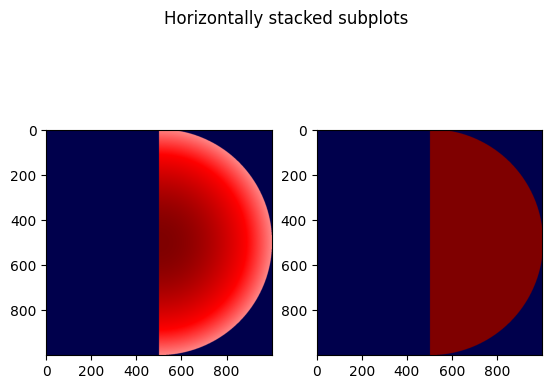

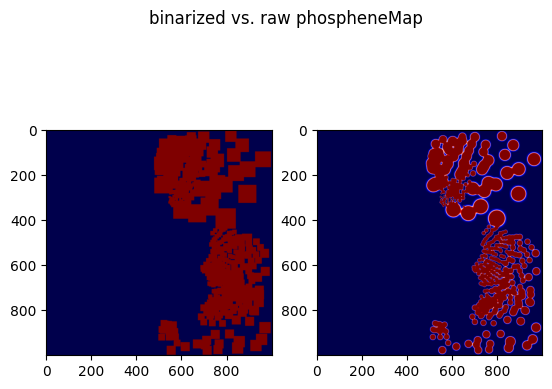

    max phospheneMap:  5.0287912e-05
     2.72 0.14 0.45 0.90 True
     2.76 0.10 0.44 0.90 True
     2.85 0.05 0.31 0.93 True
map is nan or 0
Hellington is nan or inf
     2.96 0.00 0.39 1.00 True
     2.62 0.20 0.34 0.86 True
     3.58 0.06 0.37 0.93 False
     3.67 0.01 0.39 0.97 False
map is nan or 0
Hellington is nan or inf
     2.98 0.00 0.24 1.00 True
map is nan or 0
Hellington is nan or inf
     2.96 0.00 0.36 1.00 True
     3.59 0.06 0.28 0.93 False
     2.88 0.04 0.26 0.94 True
     2.69 0.16 0.36 0.88 True
     2.67 0.17 0.34 0.87 True
     2.85 0.05 0.34 0.93 True
     2.96 0.01 0.20 0.98 True
     3.52 0.11 0.30 0.90 False
     2.42 0.35 0.46 0.81 True
     2.47 0.31 0.45 0.82 True
     2.72 0.13 0.38 0.89 True
     2.84 0.05 0.43 0.93 True
     2.88 0.03 0.38 0.95 True
     2.51 0.27 0.51 0.83 True
     2.41 0.36 0.38 0.81 True
     3.51 0.10 0.47 0.91 False
     2.31 0.43 0.45 0.78 True
     2.22 0.49 0.42 0.75 True
     2.14 0.55 0.47 0.74 True
     2.45 0.35 0.26 0.83 

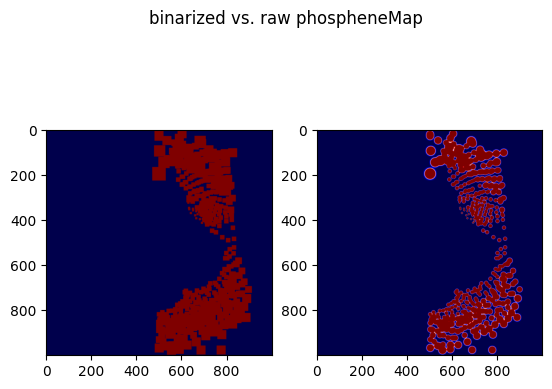

    max phospheneMap:  6.7133486e-05


In [5]:
###################
## Main Sim Loop ##
###################

# set file names
fname_ang = 'inferred_angle.mgz'
fname_ecc = 'inferred_eccen.mgz'
fname_sigma = 'inferred_sigma.mgz'
fname_anat = 'T1.mgz'
fname_aparc = 'aparc+aseg.mgz'
fname_label = 'inferred_varea.mgz'
print('number of subjects: ' + str(len(subj_list)))

# set beta angle constraints according to hemisphere
dim2_lh = Integer(name='beta', low=-15, high=110)
dim2_rh = Integer(name='beta', low=-110, high=15)

# loop through phosphene target maps and combinations of loss terms
for target_density, ftarget in zip(targ_comb, targ_names):
    for (a, b, c), floss in zip(loss_comb, loss_names):
        # set target
        target_density /= target_density.max()
        target_density /= target_density.sum()
        # can we relate bin_thesh to an eccentricity value?
        bin_thresh=np.percentile(target_density, dc_percentile ) #np.min(target_density) # bin_thesh determines size target
        target_density_bin = (target_density > bin_thresh).astype(bool)
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle('Horizontally stacked subplots')
        plt.subplot(1,2,1).imshow(target_density, cmap = 'seismic')
        plt.subplot(1,2,2).imshow(target_density_bin, cmap = 'seismic')

        for s in subj_list:
            # data_dir = datafolder + str(s)+ '/T1w/' + str(s) + '/mri/'            
            data_dir = datafolder

            if s == 'fsaverage':
                data_dir = datafolder + str(s) + '/mri/'
                
            # load maps
            ang_img = nib.load(data_dir+fname_ang)
            polar_map = ang_img.get_fdata()
            ecc_img = nib.load(data_dir+fname_ecc)
            ecc_map = ecc_img.get_fdata()
            sigma_img = nib.load(data_dir+fname_sigma)
            sigma_map = sigma_img.get_fdata()                
            aparc_img = nib.load(data_dir+fname_aparc)
            aparc_roi = aparc_img.get_fdata()
            label_img = nib.load(data_dir+fname_label)
            label_map = label_img.get_fdata()

            # compute valid voxels
            dot = (ecc_map * polar_map)
            good_coords = np.asarray(np.where(dot != 0.0))

            # filter gm per hemisphere
            cs_coords_rh = np.where(aparc_roi == 1021)
            cs_coords_lh = np.where(aparc_roi == 2021)
            gm_coords_rh = np.where((aparc_roi >= 1000) & (aparc_roi < 2000))
            gm_coords_lh = np.where(aparc_roi > 2000)
            xl,yl,zl = get_xyz(gm_coords_lh)
            xr,yr,zr = get_xyz(gm_coords_rh)
            GM_LH = np.array([xl,yl,zl]).T
            GM_RH = np.array([xr,yr,zr]).T

            # extract labels
            V1_coords_rh = np.asarray(np.where(label_map == 1))
            V1_coords_lh = np.asarray(np.where(label_map == 1))
            V2_coords_rh = np.asarray(np.where(label_map == 2))
            V2_coords_lh = np.asarray(np.where(label_map == 2))
            V3_coords_rh = np.asarray(np.where(label_map == 3))
            V3_coords_lh = np.asarray(np.where(label_map == 3))

            # divide V1 coords per hemisphere
            good_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(good_coords).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            good_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(good_coords).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V1_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V1_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V1_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V1_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V2_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V2_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V2_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V2_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T
            V3_coords_lh = np.array([x for x in set(tuple(x) for x in np.round(V3_coords_lh).T) & set(tuple(x) for x in np.round(gm_coords_lh).T)]).T
            V3_coords_rh = np.array([x for x in set(tuple(x) for x in np.round(V3_coords_rh).T) & set(tuple(x) for x in np.round(gm_coords_rh).T)]).T           

            # find center of left and right calcarine sulci
            median_lh = [np.median(cs_coords_lh[0][:]), np.median(cs_coords_lh[1][:]), np.median(cs_coords_lh[2][:])]
            median_rh = [np.median(cs_coords_rh[0][:]), np.median(cs_coords_rh[1][:]), np.median(cs_coords_rh[2][:])]

            # get GM mask and compute dorsal/posterior planes
            gm_mask = np.where(aparc_roi != 0)
            print('target: ', ftarget)
            print('loss: ', floss)
            print('a,b,c: ', a,b,c)

            # apply optimization to each hemisphere
            for gm_mask, hem, start_location, good_coords, good_coords_V1, good_coords_V2, good_coords_V3, dim2 in zip([GM_LH, GM_RH], ['LH', 'RH'], [median_lh, median_rh], [good_coords_lh, good_coords_rh], [V1_coords_lh, V1_coords_rh], [V2_coords_lh, V2_coords_rh], [V3_coords_lh, V3_coords_rh], [dim2_lh, dim2_rh]):        
                
                # check if already done
                data_id = str(s) + '_' + str(hem) + '_V1_n1000_1x10_' + floss + '_' + str(thresh) + '_' + ftarget                
                fname = '/mnt/c/DATA/NESTOR/HCP/simresults/' + data_id + 'it' + '.pkl'              
                if os.path.exists(fname):
                    print(str(s), ' ', str(hem), ' ',  str(ftarget), ' ', str(floss), ' already processed.')
                else:
                    dimensions = [dim1, dim2, dim3, dim4]

                    # create initial point generator
                    lhs2 = cook_initial_point_generator("lhs", criterion="maximin")

                    # optimize
                    res = gp_minimize(f, x0=x0, dimensions=dimensions, n_jobs=-1, n_calls=num_calls, n_initial_points=num_initial_points, initial_point_generator=lhs2, callback=[custom_stopper])

                    # print results
                    print('subject ', s, ' ', hem)
                    print('best alpha:', res.x[0])
                    print('best beta:',res.x[1])
                    print('best offset_from_base:', res.x[2])
                    print('best shank_length:',res.x[3])
                    grid_valid, dice, hell_d, grid_yield, phosphenes, phosphenes_V1, phosphenes_V2, phosphenes_V3, contacts_xyz_moved, phospheneMap = f_manual(res.x[0], res.x[1],res.x[2], res.x[3], good_coords, good_coords_V1, good_coords_V2, good_coords_V3, target_density)
                    print('best dice, yield, KL: ', dice, grid_yield, hell_d)

                    # show resulting binary phosphene map (reflects dice coefficient)
                    bin_thresh=np.percentile(phospheneMap, dc_percentile) #np.min(target_density) # bin_thesh determines size target
                    phospheneMap_bin = (phospheneMap > bin_thresh).astype(bool)
                    fig, (ax1, ax2) = plt.subplots(1, 2)
                    fig.suptitle('binarized vs. raw phospheneMap')
                    plt.subplot(1,2,1).imshow(phospheneMap_bin, cmap = 'seismic', vmin=0, vmax=np.max(phospheneMap)/100)
                    plt.subplot(1,2,2).imshow(phospheneMap, cmap = 'seismic', vmin=0, vmax=np.max(phospheneMap)/100)
                    plt.show()
                    print('    max phospheneMap: ', np.max(phospheneMap))        

                    # Saving the objects
                    data_id = str(s) + '_' + str(hem) + '_V1_n1000_1x10_' + floss + '_' + str(thresh) + '_' + ftarget                    
                    fname = outputfolder + data_id + '.pkl'
                    with open(fname, 'wb') as file:
                        pickle.dump([res, 
                                     grid_valid, 
                                     dice, hell_d, 
                                     grid_yield, 
                                     contacts_xyz_moved,
                                     good_coords,
                                     good_coords_V1,
                                     good_coords_V2,
                                     good_coords_V3,
                                     phosphenes,
                                     phosphenes_V1,
                                     phosphenes_V2,
                                     phosphenes_V3], file, protocol=-1)

[Stage-1] Rendering 475 channel maps at 256×256...
[Stage-2] Greedy selection (k=100, batch=128) minimizing Hellinger to P_all...
  - step   1/100: picked #110, batch-best H=0.70711, current H=0.70711
  - step  10/100: picked #85, batch-best H=0.90619, current H=0.90619
  - step  20/100: picked #210, batch-best H=0.80985, current H=0.80985
  - step  30/100: picked #354, batch-best H=0.75365, current H=0.75365
  - step  40/100: picked #53, batch-best H=0.71044, current H=0.71044
  - step  50/100: picked #33, batch-best H=0.67282, current H=0.67282
  - step  60/100: picked #427, batch-best H=0.63949, current H=0.63949
  - step  70/100: picked #440, batch-best H=0.60869, current H=0.60869
  - step  80/100: picked #108, batch-best H=0.58004, current H=0.58004
  - step  90/100: picked #303, batch-best H=0.55280, current H=0.55280
  - step 100/100: picked #151, batch-best H=0.52763, current H=0.52763
[Stage-3] Rendering final maps at 1000×1000 for evaluation...
[Result] Hellinger: 0.636178 |

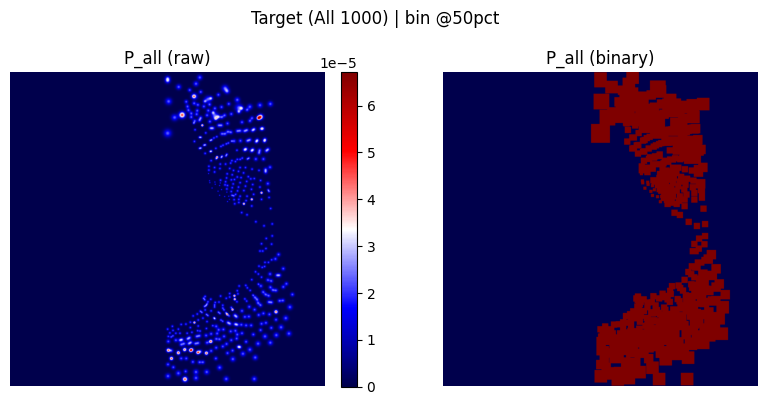

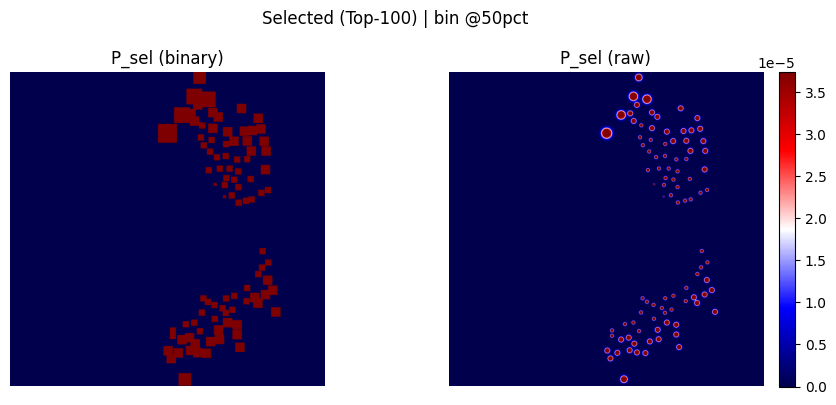

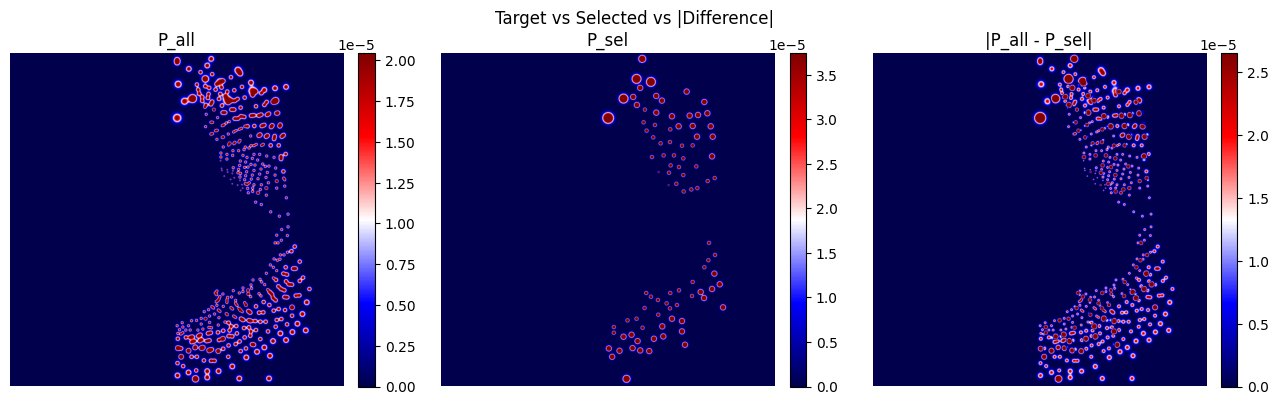

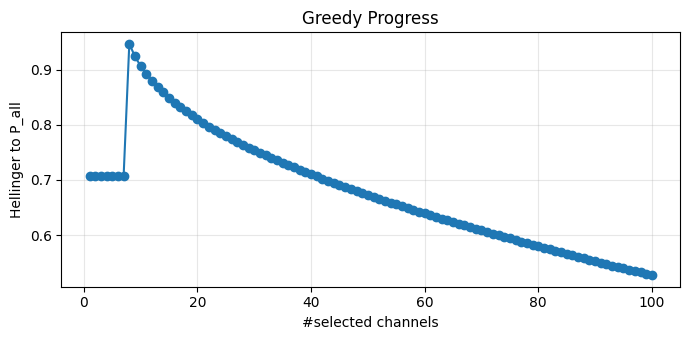

[Greedy-100]  Hellinger=0.636178 | Dice=0.508359
[Random-100]  Hellinger=0.669133 | Dice=0.532145


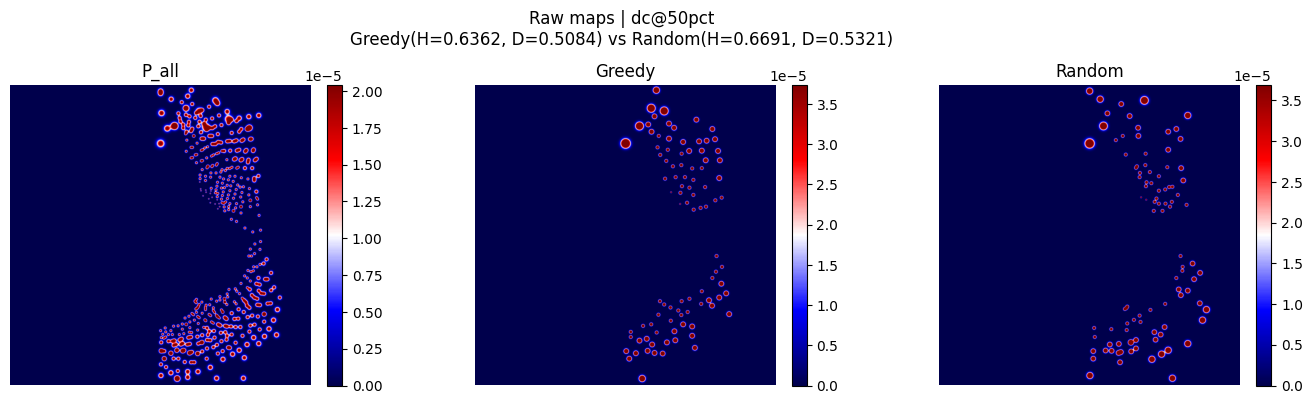

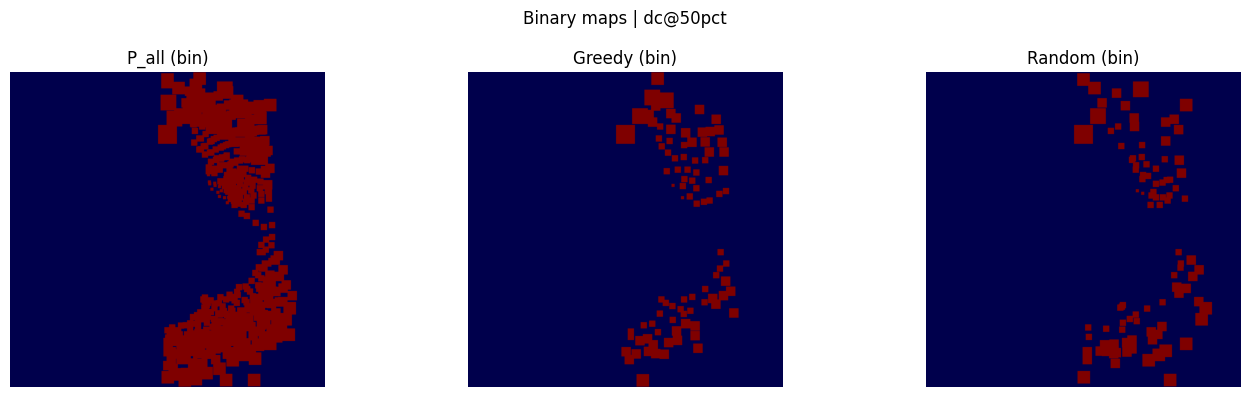

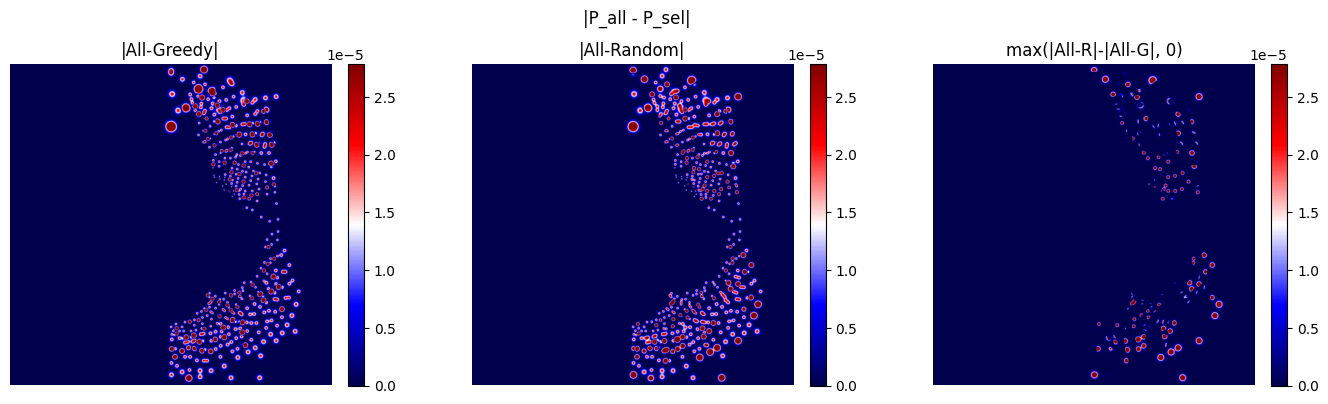

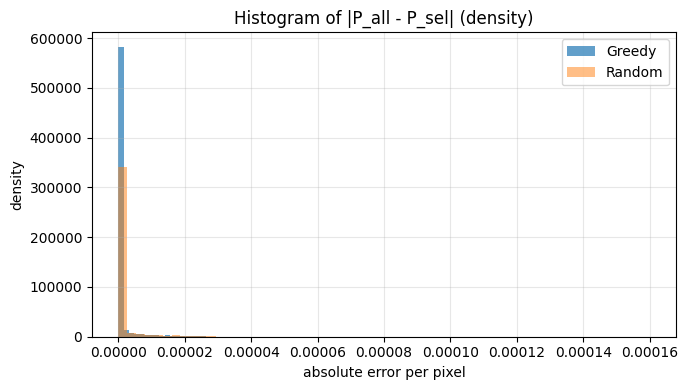

[Summary] Greedy(H=0.636178, Dice=0.508359) | Random(H=0.669133, Dice=0.532145)


In [12]:
# ============================================================
# Greedy Hellinger Matching (1000 중 100채널 선택 + 시각화/비교)
# 전제: vimplant 상단 코드가 이미 실행되어 아래 변수/함수가 있음
#   contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map,
#   cort_mag_model, amp, WINDOWSIZE, view_angle, dc_percentile, outputfolder
#   prf_to_phos, get_phosphenes, get_cortical_magnification, cortical_spread,
#   DC, hellinger_distance
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict

# ---------- 공통 유틸 ----------
def _normalize_pdf(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    """양수 맵을 확률분포로 정규화(합=1)."""
    x = np.clip(x, 0, None)
    s = x.sum()
    return x / (s + eps)

def _hellinger_batch(cands: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    배치 Hellinger 거리 계산.
    cands: (B,H,W) 확률맵, target: (H,W) 확률맵
    return: (B,)
    """
    rt = np.sqrt(target)
    rc = np.sqrt(np.clip(cands, 0, None))
    diff = rc - rt[None, ...]
    l2 = np.sqrt((diff * diff).sum(axis=(1, 2)))
    return l2 / np.sqrt(2.0)

# ---------- 채널별 파라미터/맵 ----------
def _compute_phos_params_V1(contacts_xyz_moved: np.ndarray,
                            good_coords_V1: np.ndarray,
                            polar_map: np.ndarray,
                            ecc_map: np.ndarray,
                            sigma_map: np.ndarray,
                            cort_mag_model: str,
                            amp: float) -> np.ndarray:
    """
    채널별 (angle, ecc, sigma) 반환. sigma는 CMF와 자극 확산으로 갱신.
    return: phos (N,3) with columns [angle_deg, ecc_deg, sigma_deg]
    """
    phos = get_phosphenes(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)  # (N,3)
    # sigma 재계산: CMF(deg/mm)와 조직 확산(mm) → 시야각 sigma(deg)
    M = 1.0 / get_cortical_magnification(phos[:, 1], cort_mag_model)  # deg per mm
    spread = cortical_spread(amp)                                     # mm
    sigmas = (spread * M) / 2.0                                       # deg
    phos[:, 2] = sigmas
    return phos

def _render_phi_maps(phos: np.ndarray,
                     canvas_size: int,
                     view_angle: float,
                     dtype=np.float32) -> np.ndarray:
    """
    채널별 단일 가우시안 φ_i를 캔버스에 렌더링.
    return: maps (N, canvas_size, canvas_size) 비정규화 합성 맵
    """
    N = phos.shape[0]
    maps = np.zeros((N, canvas_size, canvas_size), dtype=dtype)
    for i in range(N):
        maps[i] = prf_to_phos(np.zeros((canvas_size, canvas_size), dtype=dtype),
                              phos[i:i+1, :], view_angle=view_angle, phSizeScale=1)
    return maps

# ---------- Greedy 선택 ----------
def select_best_100_channels_greedy(k: int = 100,
                                    ds_size: int = 256,
                                    batch: int = 128,
                                    verbose: bool = True
                                   ) -> Tuple[List[int], np.ndarray, np.ndarray, Dict]:
    """
    Greedy Hellinger 최소화로 1000 채널 중 100개 선택.
    ds_size: 선정 단계 다운샘플 해상도
    batch: 후보 배치 평가 크기
    return:
      selected_indices, P_all_full, P_sel_full, metrics(dict: hellinger, dice, history_H)
    """
    # 1) 채널별 파라미터(각도/이심률/시그마) 산출
    phos = _compute_phos_params_V1(contacts_xyz_moved,
                                   good_coords_V1,
                                   polar_map, ecc_map, sigma_map,
                                   cort_mag_model, amp)
    N = phos.shape[0]
    assert N >= k, "선택할 채널 수 k가 총 채널 수보다 큽니다."

    # 2) 선정 단계: 저해상도(ds_size)로 채널별 φ_i 렌더링
    if verbose:
        print(f"[Stage-1] Rendering {N} channel maps at {ds_size}×{ds_size}...")
    phi_ds = _render_phi_maps(phos, ds_size, view_angle, dtype=np.float32)  # (N, ds, ds)

    # 전체 타깃(P_all)도 ds 해상도로
    P_all_ds = _normalize_pdf(phi_ds.sum(axis=0))

    # 3) Greedy 선택(100회)
    if verbose:
        print(f"[Stage-2] Greedy selection (k={k}, batch={batch}) minimizing Hellinger to P_all...")
    selected = []
    remain = np.arange(N)
    approx_sum = np.zeros((ds_size, ds_size), dtype=np.float32)

    # 미리 sqrt 타깃 준비(거리 계산 가속)
    sqrt_target = np.sqrt(P_all_ds)
    history_H = []

    for t in range(k):
        best_idx = None
        best_h = np.inf

        # 배치 평가
        for start in range(0, len(remain), batch):
            idx = remain[start:start+batch]
            cand_sums = approx_sum[None, :, :] + phi_ds[idx]                   # (B, ds, ds)
            denom = cand_sums.sum(axis=(1, 2), keepdims=True) + 1e-12
            cand_norm = cand_sums / denom                                      # 확률분포

            # Hellinger 계산(타깃 sqrt 미리 사용)
            rc = np.sqrt(np.clip(cand_norm, 0, None))
            diff = rc - sqrt_target[None, ...]
            l2 = np.sqrt((diff * diff).sum(axis=(1, 2)))
            hs = l2 / np.sqrt(2.0)

            j = int(np.argmin(hs))
            if hs[j] < best_h:
                best_h = float(hs[j])
                best_idx = int(idx[j])

        # 선택 반영
        selected.append(best_idx)
        approx_sum += phi_ds[best_idx]
        remain = remain[remain != best_idx]

        # 현재 근사 H 기록
        cur_norm = _normalize_pdf(approx_sum)
        cur_h = float(hellinger_distance(cur_norm.flatten(), P_all_ds.flatten()))
        history_H.append(cur_h)

        if verbose and ((t+1) % 10 == 0 or t == 0):
            print(f"  - step {t+1:3d}/{k}: picked #{best_idx}, batch-best H={best_h:.5f}, current H={cur_h:.5f}")

    # 4) 최종 평가: 원 해상도(WINDOWSIZE)로 P_all/P_sel 렌더링
    if verbose:
        print(f"[Stage-3] Rendering final maps at {WINDOWSIZE}×{WINDOWSIZE} for evaluation...")
    P_all_full = prf_to_phos(np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32),
                             phos, view_angle=view_angle, phSizeScale=1)
    P_sel_full = prf_to_phos(np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32),
                             phos[selected, :], view_angle=view_angle, phSizeScale=1)
    P_all_full = _normalize_pdf(P_all_full)
    P_sel_full = _normalize_pdf(P_sel_full)

    # 5) 지표 계산(Hellinger & Dice)
    H = float(hellinger_distance(P_sel_full.flatten(), P_all_full.flatten()))
    bin_thresh = np.percentile(P_all_full, dc_percentile)
    dice, _, _ = DC(P_all_full, P_sel_full, bin_thresh)
    if verbose:
        print(f"[Result] Hellinger: {H:.6f} | Dice: {dice:.6f} (bin@{dc_percentile}pct)")

    metrics = dict(hellinger=H, dice=float(dice), history_H=history_H)
    return selected, P_all_full, P_sel_full, metrics

# ---------- 시각화 ----------
def visualize_selection(P_all: np.ndarray,
                        P_sel: np.ndarray,
                        dc_percentile: float = 50,
                        save_prefix: str = None,
                        history_H: List[float] = None):
    """
    P_all: (H,W) 전체 1000채널 합성 확률맵
    P_sel: (H,W) 선택된 100채널 합성 확률맵
    """
    # 1) 타깃(P_all) 이진화
    thr_all = np.percentile(P_all, dc_percentile)
    P_all_bin = (P_all > thr_all).astype(bool)

    # 2) 선택(P_sel) 이진화
    thr_sel = np.percentile(P_sel, dc_percentile)
    P_sel_bin = (P_sel > thr_sel).astype(bool)

    # 3) 차이 맵
    diff = np.abs(P_all - P_sel)

    # --- Figure 1: 타깃 확률맵 vs 이진 ---
    fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
    fig1.suptitle(f"Target (All 1000) | bin @{dc_percentile}pct")
    im1 = ax1.imshow(P_all, cmap="seismic")
    ax1.set_title("P_all (raw)"); ax1.axis("off")
    im2 = ax2.imshow(P_all_bin, cmap="seismic")
    ax2.set_title("P_all (binary)"); ax2.axis("off")
    fig1.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    fig1.tight_layout()
    if save_prefix: fig1.savefig(save_prefix + "01_target_all_vs_bin.png", dpi=160)
    plt.show(); plt.close(fig1)

    # --- Figure 2: 선택 맵 이진 vs 원본 ---
    fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(9, 4))
    fig2.suptitle(f"Selected (Top-100) | bin @{dc_percentile}pct")
    vmax = np.percentile(P_sel, 99.0)
    ax3.imshow(P_sel_bin, cmap="seismic", vmin=0, vmax=1); ax3.set_title("P_sel (binary)"); ax3.axis("off")
    im4 = ax4.imshow(P_sel, cmap="seismic", vmin=0, vmax=vmax); ax4.set_title("P_sel (raw)"); ax4.axis("off")
    fig2.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
    fig2.tight_layout()
    if save_prefix: fig2.savefig(save_prefix + "02_selected_bin_vs_raw.png", dpi=160)
    plt.show(); plt.close(fig2)

    # --- Figure 3: 타깃 vs 선택 vs 절대 차이 ---
    fig3, axs = plt.subplots(1, 3, figsize=(13, 4))
    fig3.suptitle("Target vs Selected vs |Difference|")
    vmax_all = np.percentile(P_all, 99.0)
    vmax_sel = vmax
    vmax_diff = np.percentile(diff, 99.0)
    im5 = axs[0].imshow(P_all, cmap="seismic", vmin=0, vmax=vmax_all); axs[0].set_title("P_all"); axs[0].axis("off")
    im6 = axs[1].imshow(P_sel, cmap="seismic", vmin=0, vmax=vmax_sel); axs[1].set_title("P_sel"); axs[1].axis("off")
    im7 = axs[2].imshow(diff,  cmap="seismic", vmin=0, vmax=vmax_diff); axs[2].set_title("|P_all - P_sel|"); axs[2].axis("off")
    fig3.colorbar(im5, ax=axs[0], fraction=0.046, pad=0.04)
    fig3.colorbar(im6, ax=axs[1], fraction=0.046, pad=0.04)
    fig3.colorbar(im7, ax=axs[2], fraction=0.046, pad=0.04)
    fig3.tight_layout()
    if save_prefix: fig3.savefig(save_prefix + "03_target_selected_diff.png", dpi=160)
    plt.show(); plt.close(fig3)

    # --- Figure 4 (옵션): Greedy 진행 추이 ---
    if history_H is not None and len(history_H) > 0:
        fig4, ax = plt.subplots(1, 1, figsize=(7, 3.5))
        ax.plot(np.arange(1, len(history_H)+1), history_H, marker="o", lw=1.5)
        ax.set_xlabel("#selected channels"); ax.set_ylabel("Hellinger to P_all")
        ax.set_title("Greedy Progress"); ax.grid(True, alpha=0.3)
        fig4.tight_layout()
        if save_prefix: fig4.savefig(save_prefix + "04_progress_hellinger.png", dpi=160)
        plt.show(); plt.close(fig4)

# ---------- Greedy vs Random 비교 ----------
def _render_sum(phos: np.ndarray, idx: List[int], canvas_size: int, view_angle: float) -> np.ndarray:
    """선택 인덱스 집합 idx로 원 해상도 합성맵 생성 후 확률정규화"""
    if len(idx) == 0:
        return np.zeros((canvas_size, canvas_size), dtype=np.float32)
    pm = prf_to_phos(np.zeros((canvas_size, canvas_size), dtype=np.float32),
                     phos[np.array(idx), :], view_angle=view_angle, phSizeScale=1)
    return _normalize_pdf(pm)

def _metrics(P: np.ndarray, Q: np.ndarray, dc_percentile: float) -> Tuple[float, float]:
    H = float(hellinger_distance(P.flatten(), Q.flatten()))
    thr_P = np.percentile(P, dc_percentile)
    thr_Q = np.percentile(Q, dc_percentile)
    d, _, _ = DC((P > thr_P).astype(bool), (Q > thr_Q).astype(bool), 0.5)  # DC엔 이미 이진이므로 임계는 의미 없음
    return H, float(d)

def compare_random_vs_greedy(selected_idx_greedy: List[int],
                             k: int = 100,
                             dc_percentile: float = 50,
                             seed: int = 42,
                             save_prefix: str = None,
                             verbose: bool = True) -> Dict:
    """
    Greedy(100) vs Random(100) 시각/지표 비교.
    """
    # 채널별 파라미터
    phos = _compute_phos_params_V1(contacts_xyz_moved,
                                   good_coords_V1,
                                   polar_map, ecc_map, sigma_map,
                                   cort_mag_model, amp)
    N = phos.shape[0]
    assert N >= k

    # 전체 1000채널 합성 맵
    P_all = prf_to_phos(np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32),
                        phos, view_angle=view_angle, phSizeScale=1)
    P_all = _normalize_pdf(P_all)

    # Greedy/Random 선택 맵
    rng = np.random.default_rng(seed)
    random_idx = rng.choice(N, size=k, replace=False).tolist()

    P_greedy = _render_sum(phos, selected_idx_greedy, WINDOWSIZE, view_angle)
    P_rand   = _render_sum(phos, random_idx,          WINDOWSIZE, view_angle)

    # 수치 지표
    H_g, D_g = _metrics(P_all, P_greedy, dc_percentile)
    H_r, D_r = _metrics(P_all, P_rand,   dc_percentile)
    if verbose:
        print(f"[Greedy-100]  Hellinger={H_g:.6f} | Dice={D_g:.6f}")
        print(f"[Random-100]  Hellinger={H_r:.6f} | Dice={D_r:.6f}")

    # 차이 맵
    diff_g = np.abs(P_all - P_greedy)
    diff_r = np.abs(P_all - P_rand)
    vmax_diff = np.percentile(np.concatenate([diff_g.flatten(), diff_r.flatten()]), 99.0)

    # Raw 비교
    figA, axs = plt.subplots(1, 3, figsize=(14, 4))
    figA.suptitle(f"Raw maps | dc@{dc_percentile}pct\nGreedy(H={H_g:.4f}, D={D_g:.4f}) vs Random(H={H_r:.4f}, D={D_r:.4f})")
    vmax_all = np.percentile(P_all, 99.0)
    vmax_g   = np.percentile(P_greedy, 99.0)
    vmax_r   = np.percentile(P_rand, 99.0)
    imA0 = axs[0].imshow(P_all,    cmap="seismic", vmin=0, vmax=vmax_all); axs[0].set_title("P_all");   axs[0].axis("off")
    imA1 = axs[1].imshow(P_greedy, cmap="seismic", vmin=0, vmax=vmax_g);   axs[1].set_title("Greedy");  axs[1].axis("off")
    imA2 = axs[2].imshow(P_rand,   cmap="seismic", vmin=0, vmax=vmax_r);   axs[2].set_title("Random");  axs[2].axis("off")
    figA.colorbar(imA0, ax=axs[0], fraction=0.046, pad=0.04)
    figA.colorbar(imA1, ax=axs[1], fraction=0.046, pad=0.04)
    figA.colorbar(imA2, ax=axs[2], fraction=0.046, pad=0.04)
    figA.tight_layout()
    if save_prefix: figA.savefig(save_prefix + "A_raw_all_greedy_random.png", dpi=160)
    plt.show(); plt.close(figA)

    # Binary 비교
    thr_all    = np.percentile(P_all,    dc_percentile)
    thr_greedy = np.percentile(P_greedy, dc_percentile)
    thr_rand   = np.percentile(P_rand,   dc_percentile)
    B_all    = (P_all    > thr_all).astype(bool)
    B_greedy = (P_greedy > thr_greedy).astype(bool)
    B_rand   = (P_rand   > thr_rand).astype(bool)

    figB, axs = plt.subplots(1, 3, figsize=(14, 4))
    figB.suptitle(f"Binary maps | dc@{dc_percentile}pct")
    axs[0].imshow(B_all,    cmap="seismic"); axs[0].set_title("P_all (bin)");    axs[0].axis("off")
    axs[1].imshow(B_greedy, cmap="seismic"); axs[1].set_title("Greedy (bin)");   axs[1].axis("off")
    axs[2].imshow(B_rand,   cmap="seismic"); axs[2].set_title("Random (bin)");   axs[2].axis("off")
    figB.tight_layout()
    if save_prefix: figB.savefig(save_prefix + "B_bin_all_greedy_random.png", dpi=160)
    plt.show(); plt.close(figB)

    # |Difference| 비교 + 무작위가 더 나쁜 영역 하이라이트
    figC, axs = plt.subplots(1, 3, figsize=(14, 4))
    figC.suptitle("|P_all - P_sel|")
    imC0 = axs[0].imshow(diff_g, cmap="seismic", vmin=0, vmax=vmax_diff); axs[0].set_title("|All-Greedy|"); axs[0].axis("off")
    imC1 = axs[1].imshow(diff_r, cmap="seismic", vmin=0, vmax=vmax_diff); axs[1].set_title("|All-Random|"); axs[1].axis("off")
    imC2 = axs[2].imshow(np.maximum(diff_r - diff_g, 0), cmap="seismic", vmin=0, vmax=vmax_diff)
    axs[2].set_title("max(|All-R|-|All-G|, 0)"); axs[2].axis("off")
    figC.colorbar(imC0, ax=axs[0], fraction=0.046, pad=0.04)
    figC.colorbar(imC1, ax=axs[1], fraction=0.046, pad=0.04)
    figC.colorbar(imC2, ax=axs[2], fraction=0.046, pad=0.04)
    figC.tight_layout()
    if save_prefix: figC.savefig(save_prefix + "C_absdiff_compare.png", dpi=160)
    plt.show(); plt.close(figC)

    # 절대오차 분포(히스토그램)
    figD, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.hist(diff_g.flatten(), bins=60, alpha=0.7, label="Greedy", density=True)
    ax.hist(diff_r.flatten(), bins=60, alpha=0.5, label="Random", density=True)
    ax.set_title("Histogram of |P_all - P_sel| (density)")
    ax.set_xlabel("absolute error per pixel"); ax.set_ylabel("density")
    ax.grid(alpha=0.3); ax.legend()
    figD.tight_layout()
    if save_prefix: figD.savefig(save_prefix + "D_absdiff_hist.png", dpi=160)
    plt.show(); plt.close(figD)

    return {
        "random_idx":        random_idx,
        "H_greedy":          H_g, "Dice_greedy": D_g,
        "H_random":          H_r, "Dice_random": D_r,
        "P_all":             P_all,
        "P_sel_greedy":      P_greedy,
        "P_sel_random":      P_rand,
        "diff_greedy":       diff_g,
        "diff_random":       diff_r,
    }

# ===================== 실행 예시 =====================
# 선택 실행
selected_idx, P_all, P_sel, metrics = select_best_100_channels_greedy(
    k=100, ds_size=256, batch=128, verbose=True
)

# 시각화 저장 프리픽스(선택)
_save_prefix = (outputfolder + "subset_") if 'outputfolder' in globals() else None

# 선택 결과 시각화
visualize_selection(
    P_all, P_sel,
    dc_percentile=dc_percentile,
    save_prefix=_save_prefix,
    history_H=metrics.get("history_H")
)

# Greedy vs Random 비교 시각화/지표
cmp_results = compare_random_vs_greedy(
    selected_idx_greedy=selected_idx,
    k=100,
    dc_percentile=dc_percentile,
    seed=42,
    save_prefix=(outputfolder + "cmp_") if 'outputfolder' in globals() else None,
    verbose=True
)

print(f"[Summary] Greedy(H={metrics['hellinger']:.6f}, Dice={metrics['dice']:.6f}) | "
      f"Random(H={cmp_results['H_random']:.6f}, Dice={cmp_results['Dice_random']:.6f})")



Running Greedy Hellinger Matching for k=100
[Greedy] k=100, ds=256, batch=128
  step   1/100: pick #110, batch-best H=0.70711, current H=0.70711
  step  10/100: pick #85, batch-best H=0.90619, current H=0.90619
  step  20/100: pick #210, batch-best H=0.80985, current H=0.80985
  step  30/100: pick #354, batch-best H=0.75365, current H=0.75365
  step  40/100: pick #53, batch-best H=0.71044, current H=0.71044
  step  50/100: pick #33, batch-best H=0.67282, current H=0.67282
  step 100/100: pick #151, batch-best H=0.52763, current H=0.52763
  -> Result k=100: H=0.636178, Dice=0.508359


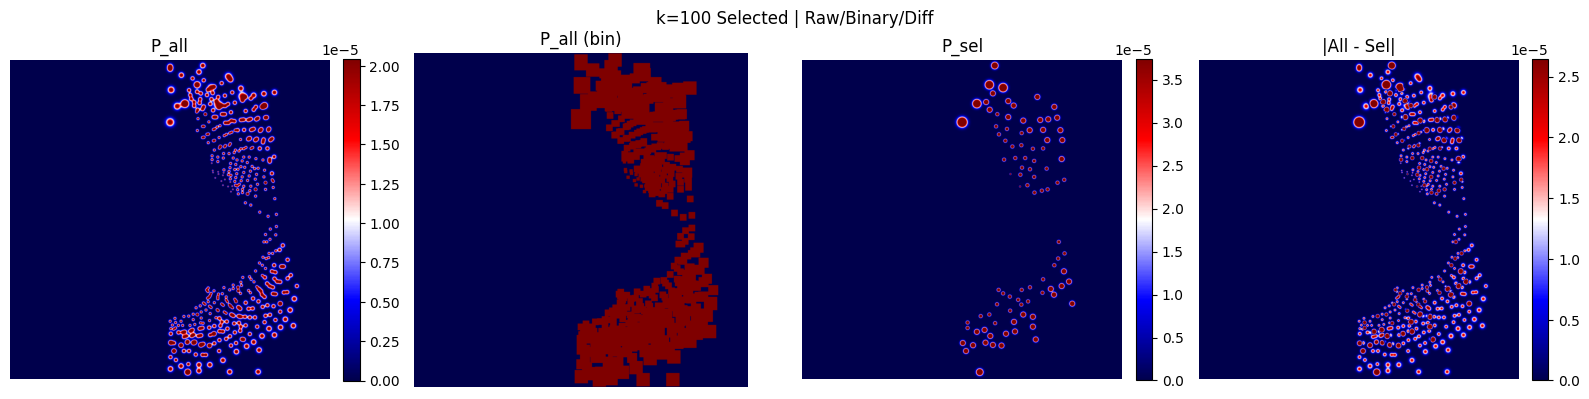

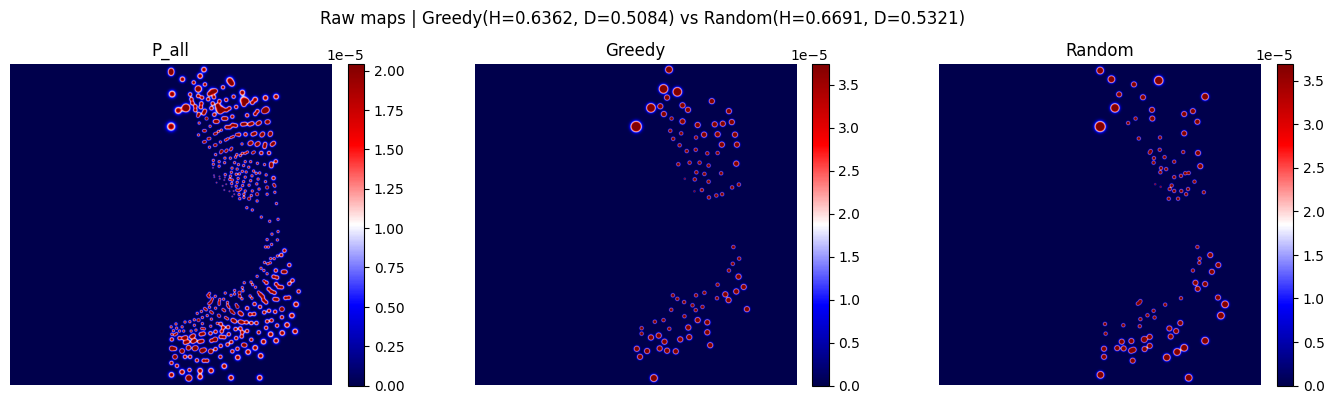

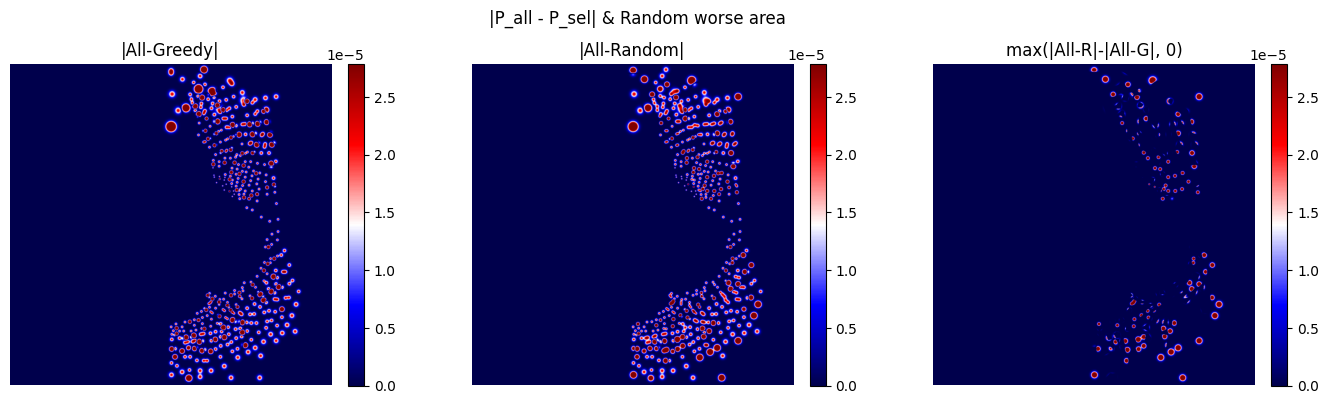

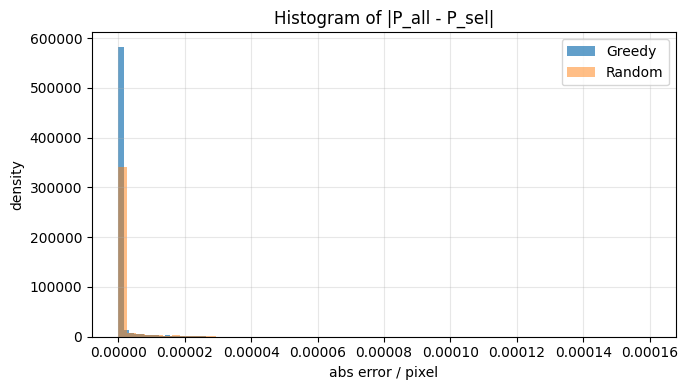


Running Greedy Hellinger Matching for k=300
[Greedy] k=300, ds=256, batch=128
  step   1/300: pick #110, batch-best H=0.70711, current H=0.70711
  step  10/300: pick #85, batch-best H=0.90619, current H=0.90619
  step  20/300: pick #210, batch-best H=0.80985, current H=0.80985
  step  30/300: pick #354, batch-best H=0.75365, current H=0.75365
  step  40/300: pick #53, batch-best H=0.71044, current H=0.71044
  step  50/300: pick #33, batch-best H=0.67282, current H=0.67282
  step 100/300: pick #151, batch-best H=0.52763, current H=0.52763
  step 150/300: pick #430, batch-best H=0.42099, current H=0.42099
  step 200/300: pick #389, batch-best H=0.34396, current H=0.34396
  step 250/300: pick #397, batch-best H=0.27148, current H=0.27148
  step 300/300: pick #34, batch-best H=0.20876, current H=0.20876
  -> Result k=300: H=0.284415, Dice=0.961024


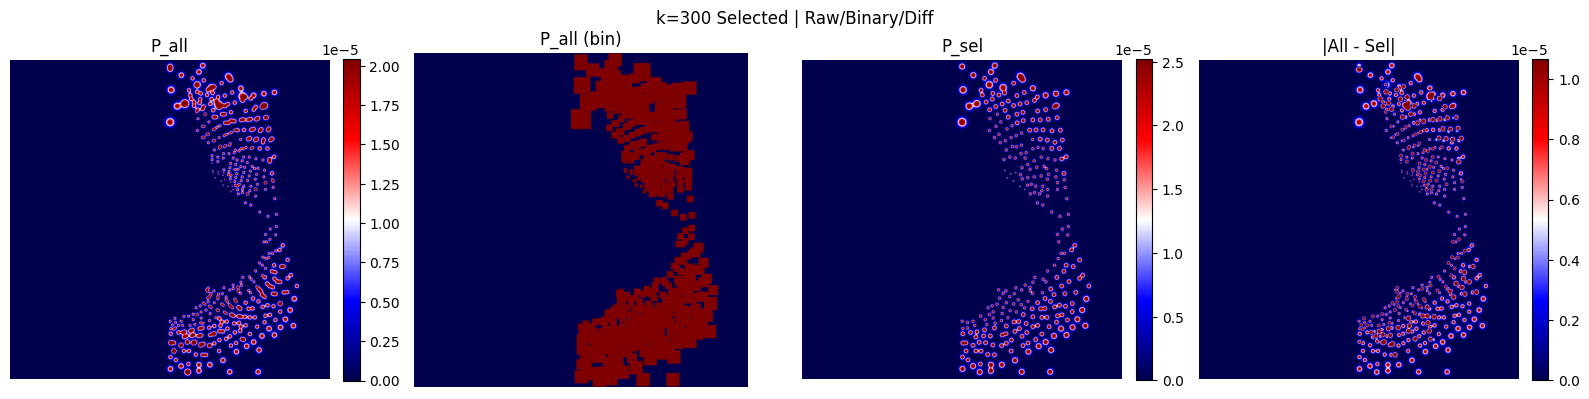

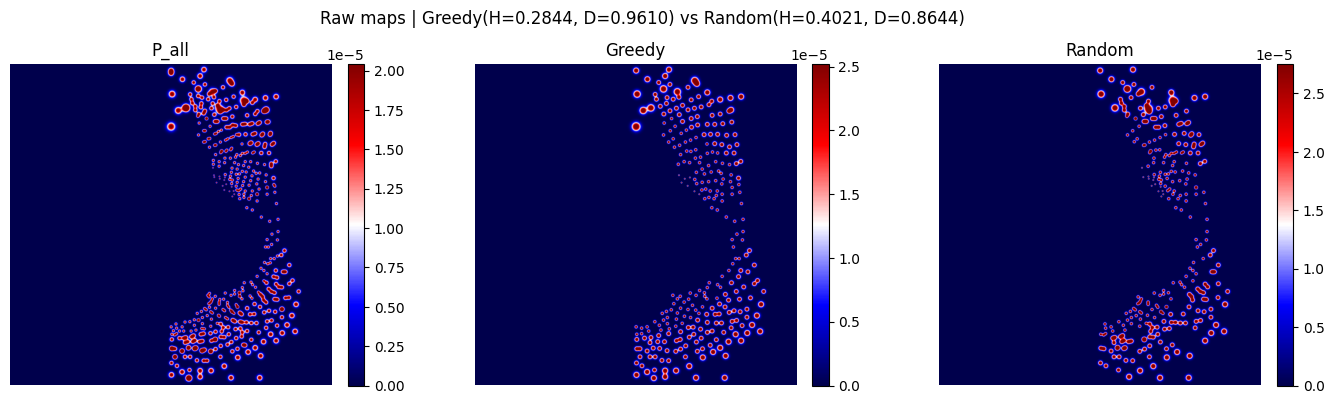

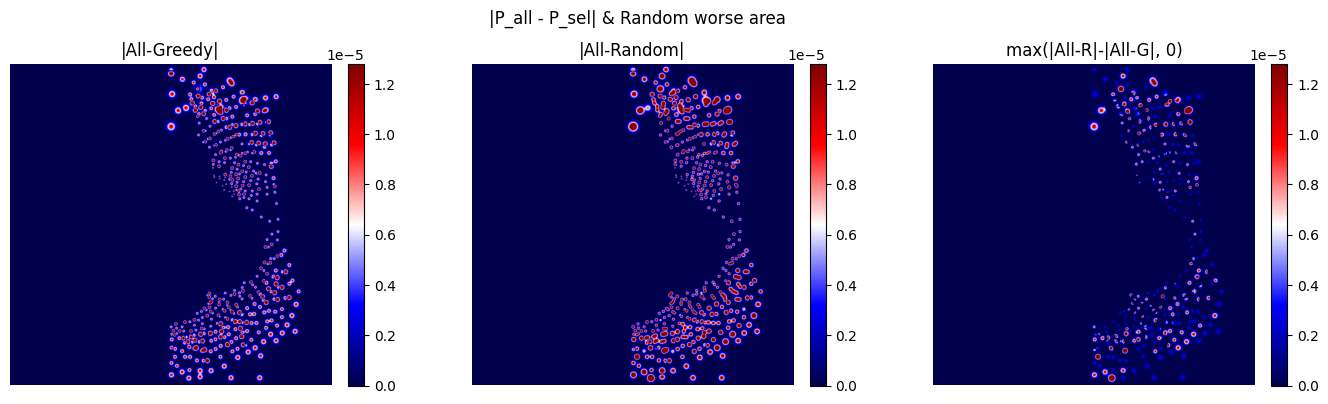

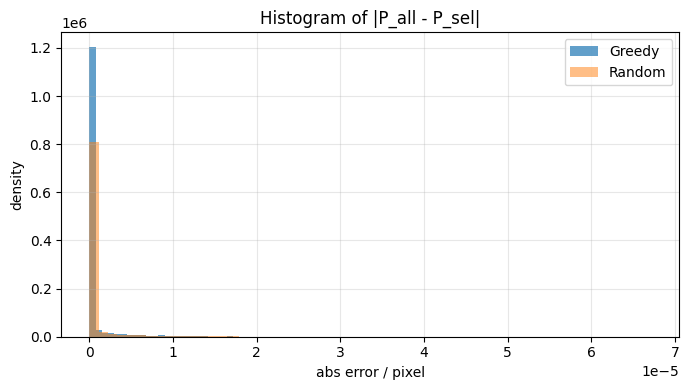


Running Greedy Hellinger Matching for k=500


AssertionError: 

In [13]:
# ============================================================
# Greedy Hellinger Matching for multiple k (100,300,500,700,900)
# - 각 k에 대해: 선택, 시각화, Greedy vs Random 비교, 지표 저장
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt

# ---------- 공통 유틸 ----------
def _normalize_pdf(x: np.ndarray, eps: float = 1e-12) -> np.ndarray:
    x = np.clip(x, 0, None)
    return x / (x.sum() + eps)

def _compute_phos_params_V1(contacts_xyz_moved,
                            good_coords_V1,
                            polar_map, ecc_map, sigma_map,
                            cort_mag_model, amp) -> np.ndarray:
    phos = get_phosphenes(contacts_xyz_moved, good_coords_V1, polar_map, ecc_map, sigma_map)  # (N,3)
    M = 1.0 / get_cortical_magnification(phos[:, 1], cort_mag_model)  # deg/mm
    spread = cortical_spread(amp)                                     # mm
    phos[:, 2] = (spread * M) / 2.0                                   # sigma(deg)
    return phos

def _render_phi_maps(phos: np.ndarray, canvas_size: int, view_angle: float, dtype=np.float32) -> np.ndarray:
    N = phos.shape[0]
    maps = np.zeros((N, canvas_size, canvas_size), dtype=dtype)
    for i in range(N):
        maps[i] = prf_to_phos(np.zeros((canvas_size, canvas_size), dtype=dtype),
                              phos[i:i+1, :], view_angle=view_angle, phSizeScale=1)
    return maps

def _render_sum(phos: np.ndarray, idx, canvas_size: int, view_angle: float) -> np.ndarray:
    if len(idx) == 0:
        return np.zeros((canvas_size, canvas_size), dtype=np.float32)
    pm = prf_to_phos(np.zeros((canvas_size, canvas_size), dtype=np.float32),
                     phos[np.array(idx), :], view_angle=view_angle, phSizeScale=1)
    return _normalize_pdf(pm)

def _metrics(P: np.ndarray, Q: np.ndarray, dc_percentile: float):
    H = float(hellinger_distance(P.flatten(), Q.flatten()))
    thr_P = np.percentile(P, dc_percentile)
    thr_Q = np.percentile(Q, dc_percentile)
    d, _, _ = DC((P > thr_P).astype(bool), (Q > thr_Q).astype(bool), 0.5)  # 이진 입력이므로 임계 무의미
    return H, float(d)

# ---------- 시각화 ----------
def _viz_pair(P_all, P_sel, title_prefix, dc_percentile=50, save_prefix=None):
    thr_all = np.percentile(P_all, dc_percentile)
    thr_sel = np.percentile(P_sel, dc_percentile)
    B_all = (P_all > thr_all).astype(bool)
    B_sel = (P_sel > thr_sel).astype(bool)
    diff = np.abs(P_all - P_sel)

    vmax_all = np.percentile(P_all, 99.0)
    vmax_sel = np.percentile(P_sel, 99.0)
    vmax_diff = np.percentile(diff, 99.0)

    # Raw vs Binary
    fig1, axs = plt.subplots(1, 4, figsize=(16, 4))
    fig1.suptitle(f"{title_prefix} | Raw/Binary/Diff")
    im0 = axs[0].imshow(P_all, cmap="seismic", vmin=0, vmax=vmax_all); axs[0].set_title("P_all"); axs[0].axis("off")
    axs[1].imshow(B_all, cmap="seismic"); axs[1].set_title("P_all (bin)"); axs[1].axis("off")
    im2 = axs[2].imshow(P_sel, cmap="seismic", vmin=0, vmax=vmax_sel); axs[2].set_title("P_sel"); axs[2].axis("off")
    im3 = axs[3].imshow(diff, cmap="seismic", vmin=0, vmax=vmax_diff); axs[3].set_title("|All - Sel|"); axs[3].axis("off")
    fig1.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    fig1.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
    fig1.colorbar(im3, ax=axs[3], fraction=0.046, pad=0.04)
    fig1.tight_layout()
    if save_prefix: fig1.savefig(save_prefix + "_raw_bin_diff.png", dpi=160)
    plt.show(); plt.close(fig1)

def _viz_greedy_vs_random(P_all, P_greedy, P_rand, dc_percentile=50, save_prefix=None):
    # 수치
    Hg, Dg = _metrics(P_all, P_greedy, dc_percentile)
    Hr, Dr = _metrics(P_all, P_rand,   dc_percentile)

    # Raw 비교
    vmax_all = np.percentile(P_all, 99.0)
    vmax_g   = np.percentile(P_greedy, 99.0)
    vmax_r   = np.percentile(P_rand, 99.0)
    figA, axs = plt.subplots(1, 3, figsize=(14, 4))
    figA.suptitle(f"Raw maps | Greedy(H={Hg:.4f}, D={Dg:.4f}) vs Random(H={Hr:.4f}, D={Dr:.4f})")
    im0 = axs[0].imshow(P_all,    cmap="seismic", vmin=0, vmax=vmax_all); axs[0].set_title("P_all");   axs[0].axis("off")
    im1 = axs[1].imshow(P_greedy, cmap="seismic", vmin=0, vmax=vmax_g);   axs[1].set_title("Greedy");  axs[1].axis("off")
    im2 = axs[2].imshow(P_rand,   cmap="seismic", vmin=0, vmax=vmax_r);   axs[2].set_title("Random");  axs[2].axis("off")
    figA.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)
    figA.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)
    figA.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)
    figA.tight_layout()
    if save_prefix: figA.savefig(save_prefix + "_A_raw_cmp.png", dpi=160)
    plt.show(); plt.close(figA)

    # Diff 비교 + 무작위가 더 나쁜 영역
    diff_g = np.abs(P_all - P_greedy)
    diff_r = np.abs(P_all - P_rand)
    vmax_diff = np.percentile(np.concatenate([diff_g.flatten(), diff_r.flatten()]), 99.0)
    figB, axs = plt.subplots(1, 3, figsize=(14, 4))
    figB.suptitle("|P_all - P_sel| & Random worse area")
    imB0 = axs[0].imshow(diff_g, cmap="seismic", vmin=0, vmax=vmax_diff); axs[0].set_title("|All-Greedy|"); axs[0].axis("off")
    imB1 = axs[1].imshow(diff_r, cmap="seismic", vmin=0, vmax=vmax_diff); axs[1].set_title("|All-Random|"); axs[1].axis("off")
    imB2 = axs[2].imshow(np.maximum(diff_r - diff_g, 0), cmap="seismic", vmin=0, vmax=vmax_diff)
    axs[2].set_title("max(|All-R|-|All-G|, 0)"); axs[2].axis("off")
    figB.colorbar(imB0, ax=axs[0], fraction=0.046, pad=0.04)
    figB.colorbar(imB1, ax=axs[1], fraction=0.046, pad=0.04)
    figB.colorbar(imB2, ax=axs[2], fraction=0.046, pad=0.04)
    figB.tight_layout()
    if save_prefix: figB.savefig(save_prefix + "_B_diff_cmp.png", dpi=160)
    plt.show(); plt.close(figB)

    # 히스토그램
    figC, ax = plt.subplots(1, 1, figsize=(7, 4))
    ax.hist(diff_g.flatten(), bins=60, alpha=0.7, label="Greedy", density=True)
    ax.hist(diff_r.flatten(), bins=60, alpha=0.5, label="Random", density=True)
    ax.set_title("Histogram of |P_all - P_sel|"); ax.set_xlabel("abs error / pixel"); ax.set_ylabel("density")
    ax.grid(alpha=0.3); ax.legend()
    figC.tight_layout()
    if save_prefix: figC.savefig(save_prefix + "_C_hist.png", dpi=160)
    plt.show(); plt.close(figC)

    return dict(H_greedy=Hg, Dice_greedy=Dg, H_random=Hr, Dice_random=Dr)

# ---------- Greedy 선택 (다운샘플/배치 크기 k에 따라 자동 튜닝) ----------
def select_greedy_for_k(phos, k, WINDOWSIZE, view_angle, dc_percentile,
                        ds_size=None, batch=None, verbose=True):
    N = phos.shape[0]
    assert N >= k

    # k가 클수록 ds_size를 낮춰 속도 확보
    if ds_size is None:
        ds_size = 256 if k <= 300 else (192 if k <= 700 else 128)
    if batch is None:
        batch = 128 if k <= 300 else 192

    if verbose:
        print(f"[Greedy] k={k}, ds={ds_size}, batch={batch}")

    # 저해상도 채널맵
    phi_ds = _render_phi_maps(phos, ds_size, view_angle, dtype=np.float32)  # (N, ds, ds)
    P_all_ds = _normalize_pdf(phi_ds.sum(axis=0))

    selected = []
    remain = np.arange(N)
    approx_sum = np.zeros((ds_size, ds_size), dtype=np.float32)
    sqrt_target = np.sqrt(P_all_ds)
    history_H = []

    for t in range(k):
        best_idx = None
        best_h = np.inf
        # 배치 후보 평가
        for start in range(0, len(remain), batch):
            idx = remain[start:start+batch]
            cand_sums = approx_sum[None, :, :] + phi_ds[idx]
            cand_norm = cand_sums / (cand_sums.sum(axis=(1,2), keepdims=True) + 1e-12)
            rc = np.sqrt(np.clip(cand_norm, 0, None))
            diff = rc - sqrt_target[None, ...]
            l2 = np.sqrt((diff * diff).sum(axis=(1,2)))
            hs = l2 / np.sqrt(2.0)
            j = int(np.argmin(hs))
            if hs[j] < best_h:
                best_h = float(hs[j]); best_idx = int(idx[j])

        selected.append(best_idx)
        approx_sum += phi_ds[best_idx]
        remain = remain[remain != best_idx]

        cur_norm = _normalize_pdf(approx_sum)
        cur_h = float(hellinger_distance(cur_norm.flatten(), P_all_ds.flatten()))
        history_H.append(cur_h)

        if verbose and ((t+1) % 50 == 0 or t in (0, 9, 19, 29, 39)):
            print(f"  step {t+1:3d}/{k}: pick #{best_idx}, batch-best H={best_h:.5f}, current H={cur_h:.5f}")

    # 원 해상도 평가
    P_all_full = _normalize_pdf(
        prf_to_phos(np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32),
                    phos, view_angle=view_angle, phSizeScale=1)
    )
    P_sel_full = _normalize_pdf(
        prf_to_phos(np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32),
                    phos[selected, :], view_angle=view_angle, phSizeScale=1)
    )

    H = float(hellinger_distance(P_sel_full.flatten(), P_all_full.flatten()))
    bin_thresh = np.percentile(P_all_full, dc_percentile)
    dice, _, _ = DC(P_all_full, P_sel_full, bin_thresh)
    if verbose:
        print(f"  -> Result k={k}: H={H:.6f}, Dice={dice:.6f}")

    return selected, P_all_full, P_sel_full, dict(hellinger=H, dice=float(dice), history_H=history_H)

# ---------- 메인 실행: k 리스트 일괄 처리 ----------
k_list = [100, 300, 500, 700, 900]

# 출력 폴더 준비
save_root = outputfolder if 'outputfolder' in globals() else "./"
os.makedirs(save_root, exist_ok=True)

# 채널별 파라미터 1회 계산(파라미터 고정 가정)
phos_all = _compute_phos_params_V1(contacts_xyz_moved,
                                   good_coords_V1,
                                   polar_map, ecc_map, sigma_map,
                                   cort_mag_model, amp)

# 전체 1000채널 기준 타깃 맵(원 해상도)
P_all_full = _normalize_pdf(
    prf_to_phos(np.zeros((WINDOWSIZE, WINDOWSIZE), dtype=np.float32),
                phos_all, view_angle=view_angle, phSizeScale=1)
)

summary = []  # (k, H_g, D_g, H_r, D_r)

for k in k_list:
    print("\n" + "="*70)
    print(f"Running Greedy Hellinger Matching for k={k}")
    print("="*70)

    # Greedy 선택 및 시각화
    selected_k, _, P_sel_k, metrics_k = select_greedy_for_k(
        phos_all, k, WINDOWSIZE, view_angle, dc_percentile, ds_size=None, batch=None, verbose=True
    )

    prefix_k = os.path.join(save_root, f"k{k:03d}")
    _viz_pair(P_all_full, P_sel_k, title_prefix=f"k={k} Selected", dc_percentile=dc_percentile,
              save_prefix=prefix_k)

    # Greedy vs Random 비교 + 저장
    rng = np.random.default_rng(42)
    random_idx = rng.choice(phos_all.shape[0], size=k, replace=False).tolist()
    P_rand_k = _render_sum(phos_all, random_idx, WINDOWSIZE, view_angle)
    cmp_k = _viz_greedy_vs_random(P_all_full, P_sel_k, P_rand_k,
                                  dc_percentile=dc_percentile, save_prefix=prefix_k)

    summary.append((k, metrics_k["hellinger"], metrics_k["dice"],
                    cmp_k["H_random"], cmp_k["Dice_random"]))

    # npz 저장(선택 인덱스/맵/지표)
    np.savez(prefix_k + "_results.npz",
             k=np.array(k),
             selected_idx=np.array(selected_k, dtype=np.int32),
             P_all=P_all_full, P_sel=P_sel_k, P_rand=P_rand_k,
             H_greedy=metrics_k["hellinger"], Dice_greedy=metrics_k["dice"],
             H_random=cmp_k["H_random"], Dice_random=cmp_k["Dice_random"],
             history_H=np.array(metrics_k["history_H"], dtype=np.float32))

# 요약 표 저장/출력
summary = np.array(summary, dtype=float)
header = "k, H_greedy, Dice_greedy, H_random, Dice_random"
np.savetxt(os.path.join(save_root, "summary_k100_900.csv"),
           summary, delimiter=",", header=header, comments="", fmt="%.6f")

print("\n=== Summary (k, H_greedy, Dice_greedy, H_random, Dice_random) ===")
for row in summary:
    print(f"k={int(row[0])} | Greedy H={row[1]:.6f}, D={row[2]:.6f} | Random H={row[3]:.6f}, D={row[4]:.6f}")
